In [1]:
import valenspy as vp
from valenspy.processing import select_region, remap_cdo
from dask.diagnostics import ProgressBar
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
from datatree import DataTree

# Data loading and processing
All the data loading and preprocessing is done using valenspy but in through a submission of the regrid_data.py script. 

# Analysis
By saving the data to a file, we could load the data from here and continue the analysis

In [2]:
# dt.to_netcdf("...")
# dt.to_zarr("...")

In [6]:
import datatree

dt = datatree.open_datatree("/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/ValEnsPy/notebooks/intermediate_data/preprocessed_data_2006_ERA5_all.nc", chunks="auto")

In [7]:
dt

DataTree('None', parent=None)
├── DataTree('obs')
│   └── DataTree('ERA5')
│           Dimensions:  (time: 8736, lat: 141, lon: 221)
│           Coordinates:
│             * lon      (lon) float32 884B -15.0 -14.75 -14.5 -14.25 ... 39.5 39.75 40.0
│             * lat      (lat) float32 564B 35.0 35.25 35.5 35.75 ... 69.25 69.5 69.75 70.0
│             * time     (time) datetime64[ns] 70kB 2006-01-01 ... 2006-12-30T23:00:00
│           Data variables:
│               tas      (time, lat, lon) float64 2GB dask.array<chunksize=(3504, 55, 87), meta=np.ndarray>
│               pr       (time, lat, lon) float64 2GB dask.array<chunksize=(3504, 55, 87), meta=np.ndarray>
│           Attributes:
│               Conventions:  CF-1.6
│               history:      2020-02-19 04:37:50 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
│               period:       2006
│               freq:         hourly
│               region:       europe
│               dataset:      ERA5
└── DataTree('mod')
    ├── DataTree('ALARO_original')
    │       Dimensions:  (time: 8614, lon: 221, lat: 141)
    │       Coordinates:
    │         * time     (time) datetime64[ns] 69kB 2006-01-01T01:00:00 ... 2006-12-30T23...
    │         * lon      (lon) float64 2kB -15.0 -14.75 -14.5 -14.25 ... 39.5 39.75 40.0
    │         * lat      (lat) float64 1kB 35.0 35.25 35.5 35.75 ... 69.25 69.5 69.75 70.0
    │       Data variables:
    │           tas      (time, lat, lon) float32 1GB dask.array<chunksize=(1076, 141, 221), meta=np.ndarray>
    │           pr       (time, lat, lon) float64 2GB dask.array<chunksize=(538, 141, 221), meta=np.ndarray>
    │       Attributes: (12/23)
    │           ey:           13
    │           dy:           12500
    │           projection:   lcc
    │           center_lon:   9.9
    │           origin:       /dodrio/scratch/projects/2022_200/project_output/RMIB-UGent...
    │           dx:           12500
    │           ...           ...
    │           history:      Wed Oct 02 15:06:56 2024: cdo -O -s -f nc -remapbil,/dodrio...
    │           center_lat:   49
    │           validate:     2006-01-01 01:00:00
    │           timestep:     300
    │           basedate:     2006-01-01
    │           proj_R:       6371229
    ├── DataTree('ALARO_GHGs')
    │       Dimensions:  (time: 8734, lon: 221, lat: 141)
    │       Coordinates:
    │         * time     (time) datetime64[ns] 70kB 2006-01-01T01:00:00 ... 2006-12-30T23...
    │         * lon      (lon) float64 2kB -15.0 -14.75 -14.5 -14.25 ... 39.5 39.75 40.0
    │         * lat      (lat) float64 1kB 35.0 35.25 35.5 35.75 ... 69.25 69.5 69.75 70.0
    │       Data variables:
    │           tas      (time, lat, lon) float32 1GB dask.array<chunksize=(1076, 141, 221), meta=np.ndarray>
    │           pr       (time, lat, lon) float64 2GB dask.array<chunksize=(538, 141, 221), meta=np.ndarray>
    │       Attributes: (12/23)
    │           ey:           13
    │           dy:           12500
    │           projection:   lcc
    │           center_lon:   9.9
    │           origin:       /dodrio/scratch/projects/2022_200/project_output/RMIB-UGent...
    │           dx:           12500
    │           ...           ...
    │           history:      Wed Oct 02 15:23:13 2024: cdo -O -s -f nc -remapbil,/dodrio...
    │           center_lat:   49
    │           validate:     2006-01-01 01:00:00
    │           timestep:     300
    │           basedate:     2006-01-01
    │           proj_R:       6371229
    ├── DataTree('ALARO_GHGs_TRIPLE')
    │       Dimensions:  (time: 8734, lon: 221, lat: 141)
    │       Coordinates:
    │         * time     (time) datetime64[ns] 70kB 2006-01-01T01:00:00 ... 2006-12-30T23...
    │         * lon      (lon) float64 2kB -15.0 -14.75 -14.5 -14.25 ... 39.5 39.75 40.0
    │         * lat      (lat) float64 1kB 35.0 35.25 35.5 35.75 ... 69.25 69.5 69.75 70.0
    │       Data variables:
    │           tas      (time, lat, lon) float32 1GB dask.array<chunksize=

## Final preparation
Some final preparation before running the diagnostics.
Such as choosing a period of interest, and a domain.

In [8]:
dt = dt.sel(time=slice("2006-06-01","2006-06-31")) #Select only the last three months (here the temporal spin-up is already considered)
dt = dt.map_over_subtree(select_region, region="europe") #Select region

# Diagnostics
A quick comparison between the data.



### Model2Ref



In [9]:
SpatialBias_ens = vp.Ensemble2Ref.from_model2ref(vp.diagnostic.SpatialBias)

with ProgressBar():
    dt_spatial_bias = SpatialBias_ens.apply(dt.mod, dt["obs/ERA5"].ds).compute()

[########################################] | 100% Completed | 28.89 s
[########################################] | 100% Completed | 27.13 s
[########################################] | 100% Completed | 29.48 s
[########################################] | 100% Completed | 26.04 s
[########################################] | 100% Completed | 24.27 s
[########################################] | 100% Completed | 24.52 s


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/valenspy_dev/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/valenspy_dev/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/valenspy_dev/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/valenspy_dev/lib/python3.9/site-packages/cartopy/m

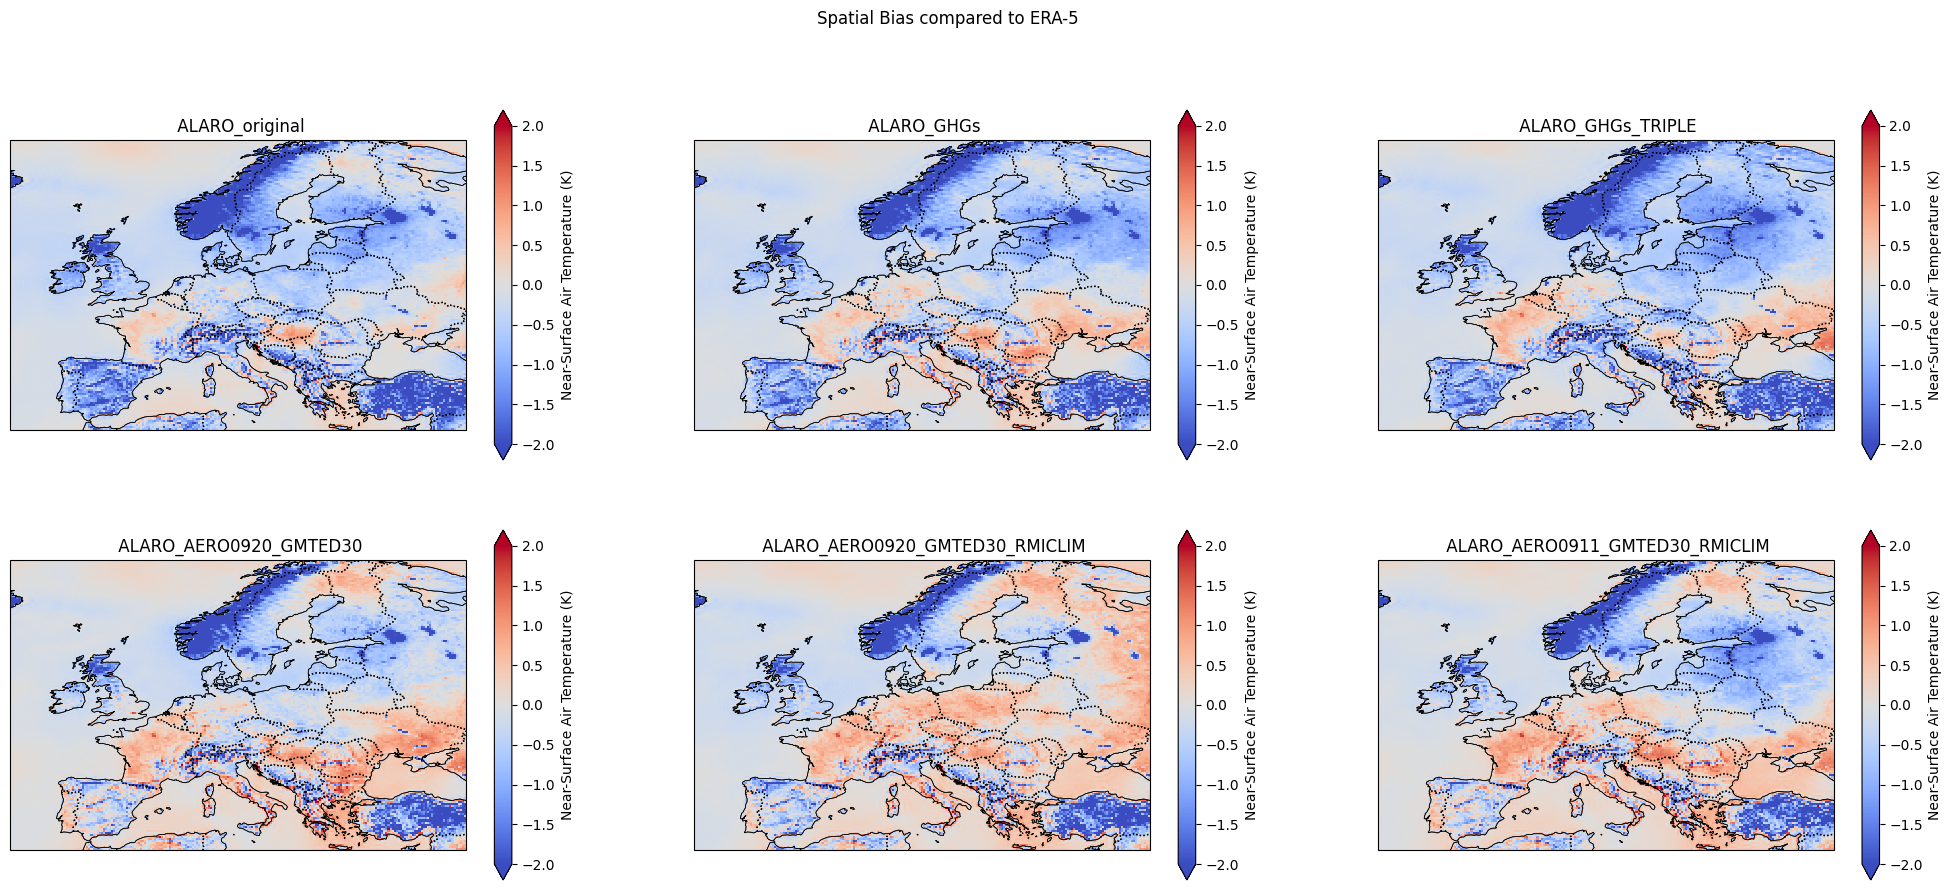

In [16]:
from valenspy.diagnostic.visualizations import plot_map
import cartopy.crs as ccrs
fig, ax = plt.subplots(2,3, figsize=(25,10), subplot_kw={"projection":ccrs.PlateCarree()})
SpatialBias_ens.plot(dt_spatial_bias, axes=ax, variable="tas", facetted=True, robust=True, vmin=-2, vmax=2)
# plot_map(dt.obs.ERA5.ds["tas"].mean("time"), ax=ax[1], cmap="coolwarm", cbar_kwargs={"shrink":0.6})
# ax[1].set_title("ERA-5 mean")
fig.suptitle("Spatial Bias compared to ERA-5")
plt.show()

/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/valenspy_dev/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/valenspy_dev/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/valenspy_dev/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/valenspy_dev/lib/python3.9/site-packages/cartopy/m

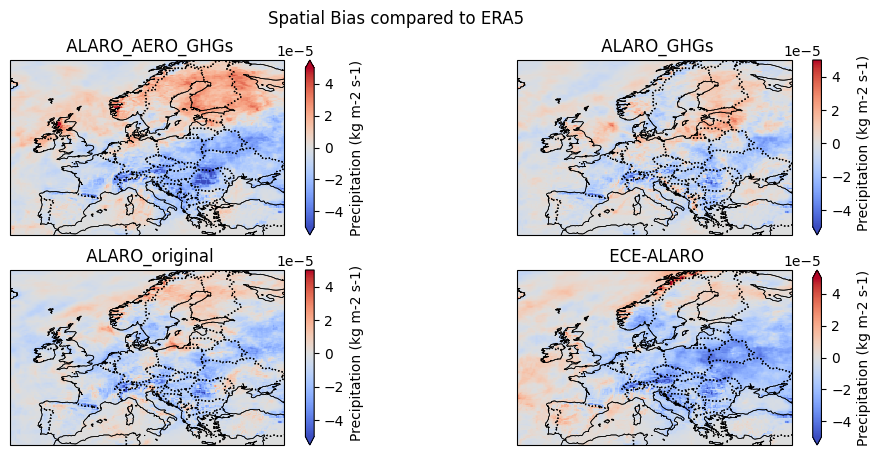

In [85]:
import cartopy.crs as ccrs
fig, ax = plt.subplots(2,2, figsize=(12,5), subplot_kw={"projection":ccrs.PlateCarree()})
SpatialBias_ens.plot(dt_spatial_bias, axes=ax, variable="pr", facetted=True, vmin=-5e-5, vmax=5e-5)
# dt["obs/ERA5"].ds["tas"].mean("time").plot(ax=ax[1,1], transform=ccrs.PlateCarree(), label="ERA5")
fig.suptitle("Spatial Bias compared to ERA5")
plt.show()

### Model2Self
Some diagnostics to compare the model to itself
### Diurnal cycle

In [28]:
DiurnalCycle_ens = vp.Ensemble2Self.from_model2self(vp.diagnostic.DiurnalCycle)
with ProgressBar():
    dt_diurnal_cycle = DiurnalCycle_ens.apply(dt).compute()

[########################################] | 100% Completed | 5.17 ss
[########################################] | 100% Completed | 1.22 sms
[########################################] | 100% Completed | 1.53 sms
[########################################] | 100% Completed | 1.65 sms
[########################################] | 100% Completed | 3.31 sms


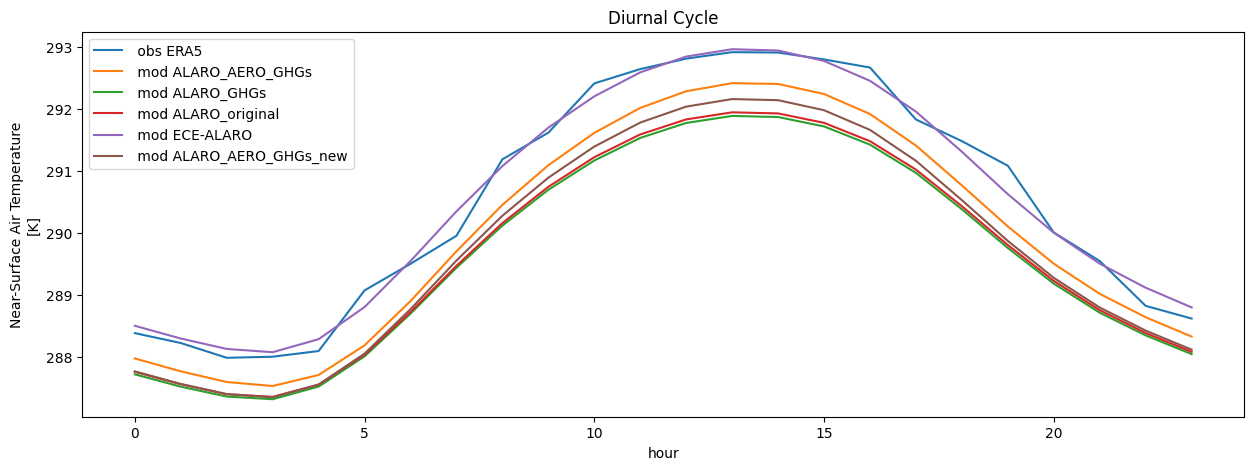

In [29]:
fig,ax = plt.subplots(1,1, figsize=(15,5))
DiurnalCycle_ens.plot(dt_diurnal_cycle, facetted=False, variable="tas", axes=ax)
plt.legend()

### Time series

In [30]:
from valenspy.diagnostic import TimeSeriesSpatialMean
TimeSeriesSpatialMean_ens = vp.Ensemble2Self.from_model2self(TimeSeriesSpatialMean)

with ProgressBar():
    dt_ts = TimeSeriesSpatialMean_ens.apply(dt).compute()

[########################################] | 100% Completed | 5.01 ss
[########################################] | 100% Completed | 1.32 sms
[########################################] | 100% Completed | 1.74 sms
[########################################] | 100% Completed | 1.63 sms
[########################################] | 100% Completed | 4.06 sms


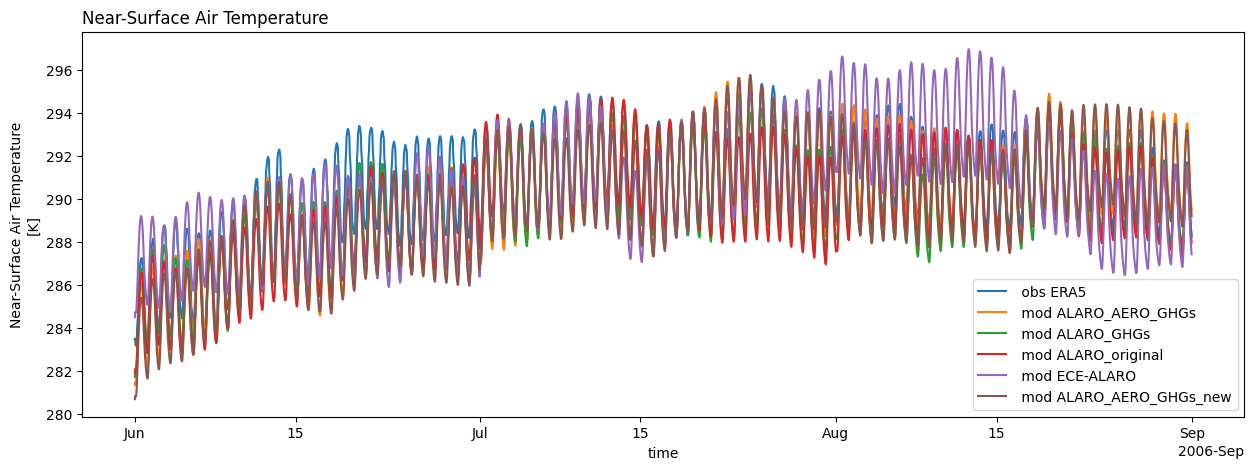

In [31]:
fig,ax = plt.subplots(1,1, figsize=(15,5))
TimeSeriesSpatialMean_ens.plot(dt_ts, variable="tas", axes=ax, facetted=False)
plt.legend()
plt.show()

## Point analysis

/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/valenspy_dev/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


<GeoAxes: title={'right': 'Location of points'}>

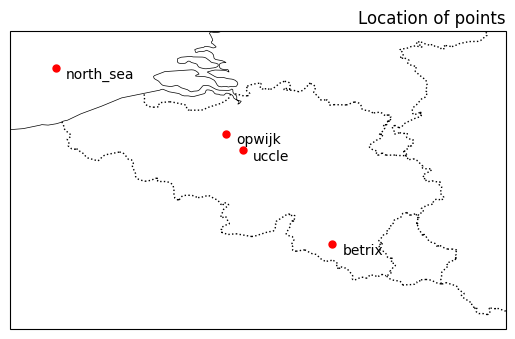

In [35]:
from valenspy.processing.select import select_point
from valenspy.diagnostic.visualizations import plot_points_on_map

d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
    'uccle'     : (4.35, 50.8),
}

point_id = "opwijk"
point_coord = d_point_coords[point_id]

plot_points_on_map(d_point_coords, region="belgium")

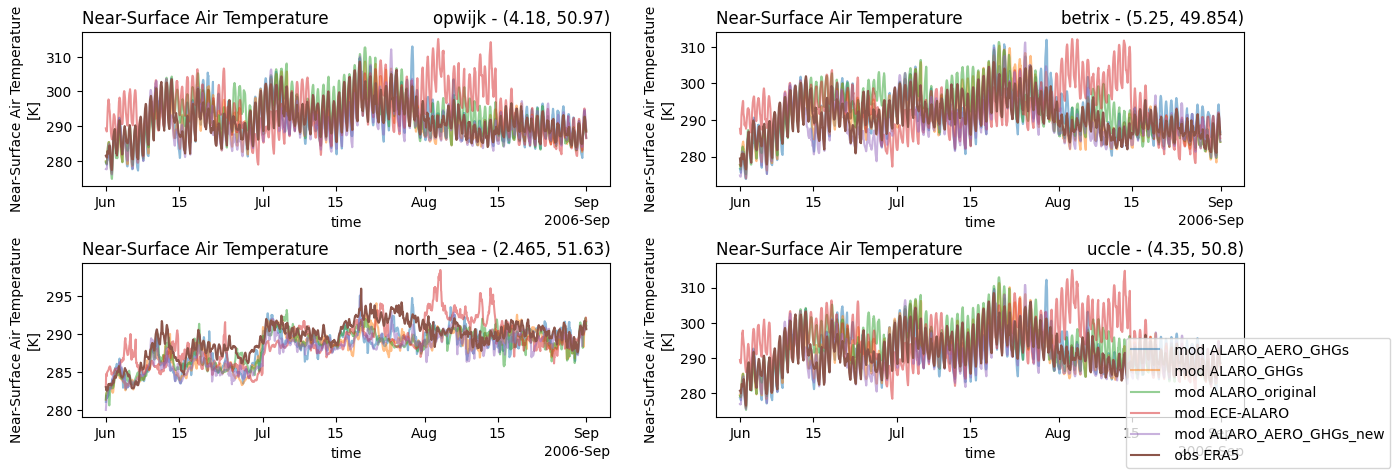

In [36]:
fig, axes = plt.subplots(2,2 , figsize=(15,5))
for point, ax in zip(d_point_coords.keys(), axes.flatten()):
    dt_point = dt.map_over_subtree(select_point, (d_point_coords[point][0], d_point_coords[point][1]))
    TimeSeriesSpatialMean_ens.plot(dt_point.mod, variable="tas", axes=ax, facetted=False, alpha=0.5)
    TimeSeriesSpatialMean_ens.plot(dt_point.obs, variable="tas", axes=ax, facetted=False)
    ax.set_title(f"{point} - ({d_point_coords[point][0]}, {d_point_coords[point][1]})", loc="right")

#Add legend
handles, labels = ax.get_legend_handles_labels()
fig.subplots_adjust(hspace=0.5)
fig.legend(handles, labels, loc='lower right')

#Add the plot_points_on_map(d_point_coords, region="belgium") to the plot in the top right corner


plt.show()

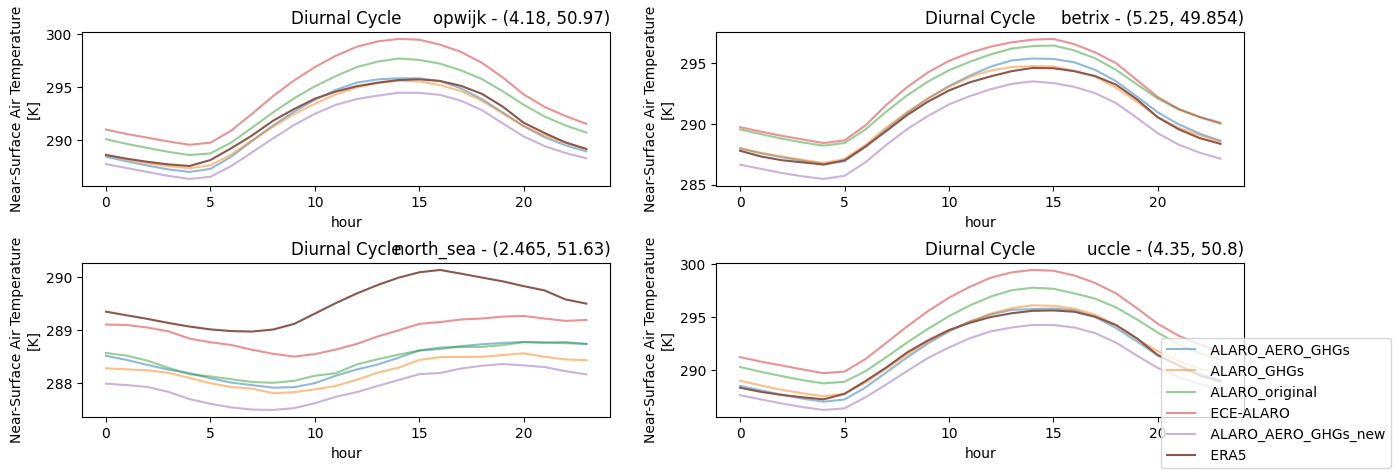

In [37]:
fig, axes = plt.subplots(2,2 , figsize=(15,5))
for point, ax in zip(d_point_coords.keys(), axes.flatten()):
    dt_point = dt.map_over_subtree(select_point, (d_point_coords[point][0], d_point_coords[point][1]))
    DiurnalCycle_ens.plot(DiurnalCycle_ens.apply(dt_point.mod), variable="tas", axes=ax, facetted=False, alpha=0.5)
    DiurnalCycle_ens.plot(DiurnalCycle_ens.apply(dt_point.obs), variable="tas", axes=ax, facetted=False)
    ax.set_title(f"{point} - ({d_point_coords[point][0]}, {d_point_coords[point][1]})", loc="right")

#Add legend
handles, labels = ax.get_legend_handles_labels()
fig.subplots_adjust(hspace=0.5)
fig.legend(handles, labels, loc='lower right')

plt.show()

## Heat waves
- July 12 to 19, 2006


In [62]:
period = slice("2006-07-12","2006-07-19")

ds = dt["obs/ERA5"].ds
ds_points = select_point(ds, point_coord)
ds_points

<xarray.Dataset> Size: 53kB
Dimensions:  (time: 2208)
Coordinates:
    lon      float32 4B 4.25
    lat      float32 4B 51.0
  * time     (time) datetime64[ns] 18kB 2006-06-01 ... 2006-08-31T23:00:00
Data variables:
    tas      (time) float64 18kB dask.array<chunksize=(20,), meta=np.ndarray>
    pr       (time) float64 18kB dask.array<chunksize=(20,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-02-19 04:37:50 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
    period:       2006
    freq:         hourly
    region:       europe
    dataset:      ERA5

In [ ]:
def Event(ds, period):
    ds_spatial_max = ds.sel(time=period).max("time")
    ds_spatial_min = ds.sel(time=period).min("time")
    ds_spatial_mean = ds.sel(time=period).mean("time")
    ds_time_series = ds.sel(time=period)
    return ds.sel(time=period)

/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/valenspy_dev/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/valenspy_dev/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


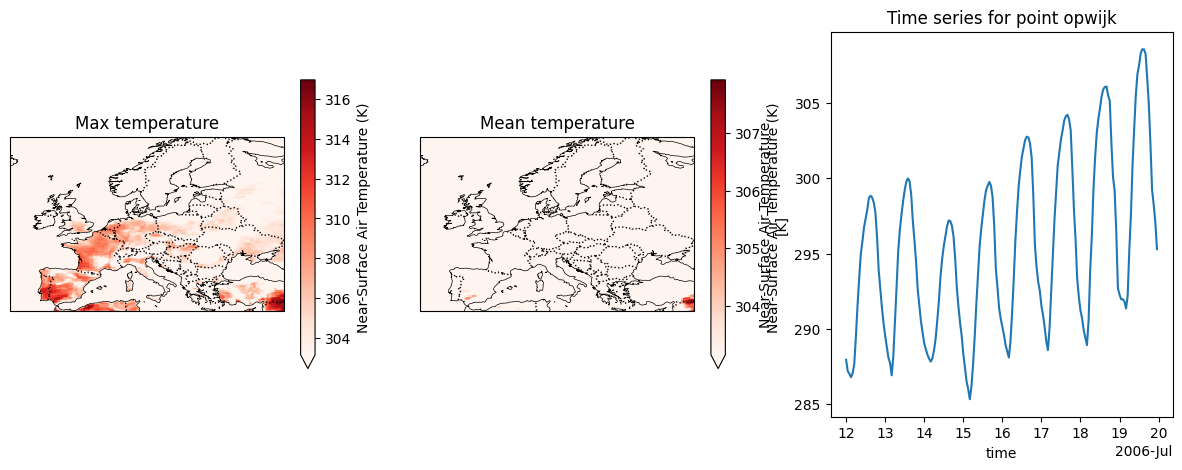

In [63]:
#Draw heat wave statistics for the given week.
from valenspy.diagnostic_visualizations import plot_map
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
plot_map(ds["tas"].sel(time=period).max("time"), ax=ax1, cbar_kwargs={"shrink":0.75}, cmap = "Reds", vmin=303.15)
ax1.set_title("Max temperature")

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
plot_map(ds["tas"].sel(time=period).mean("time"), ax=ax2, cbar_kwargs={"shrink":0.75}, cmap = "Reds", vmin=303.15)
ax2.set_title("Mean temperature")

ax3 = fig.add_subplot(133)
ds_points["tas"].sel(time=period).plot(ax=ax3)
ax3.set_title(f"Time series for point {point_id}")

plt.show()


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/valenspy_dev/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/valenspy_dev/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


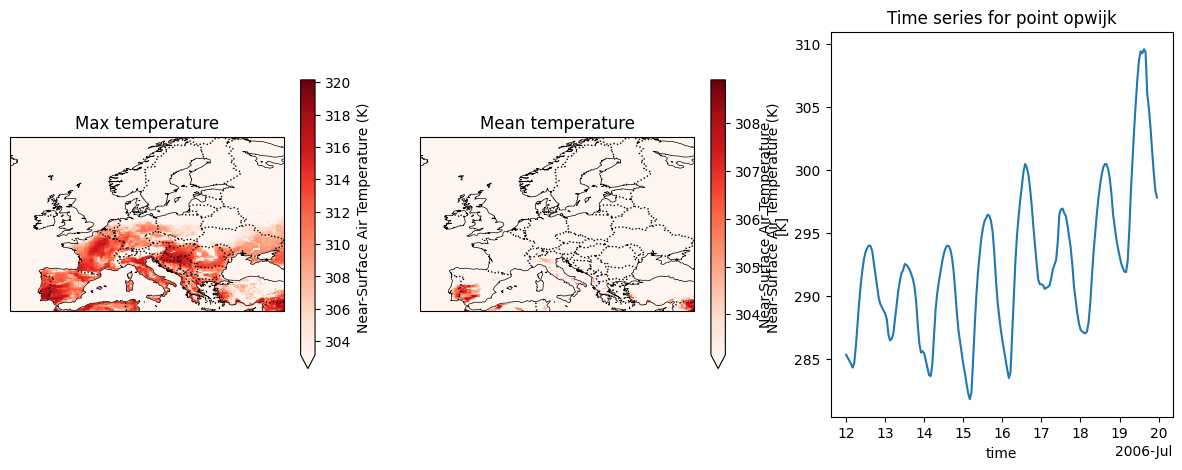

In [64]:
ds = dt["mod/ALARO_AERO_GHGs"].ds
ds_points = select_point(ds, point_coord)
ds_points

#Draw heat wave statistics for the given week.
from valenspy.diagnostic_visualizations import plot_map
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
plot_map(ds["tas"].sel(time=period).max("time"), ax=ax1, cbar_kwargs={"shrink":0.75}, cmap = "Reds", vmin=303.15)
ax1.set_title("Max temperature")

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
plot_map(ds["tas"].sel(time=period).mean("time"), ax=ax2, cbar_kwargs={"shrink":0.75}, cmap = "Reds", vmin=303.15)
ax2.set_title("Mean temperature")

ax3 = fig.add_subplot(133)
ds_points["tas"].sel(time=period).plot(ax=ax3)
ax3.set_title(f"Time series for point {point_id}")

plt.show()